### Make plots of latitude-pressure plots of zonal temperature

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as py
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import xesmf as xe
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from functools import reduce
import cmocean

Function to compute the required climatological data

In [2]:
def find_common_pressure_levels(plev1,
                                plev2,
                                plev3):

    # Find the common pressure levels for three inputs
    clevels=reduce(np.intersect1d,(plev1,plev2,plev3))

    return clevels
                                

In [3]:
def get_climo(start_year,
              end_year,
              ds_in_full,
              clevels):
    
    # Get the model fields and average them
    print("get_climo")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years and pressure levels we need, can really speed things up..
    ds_in = ds_in_full['ta'].sel(time=slice(year1, year2),plev=clevels)

    # Group the data by seasons, compute the seasonal and zonal means
    month_length = ds_in.time.dt.days_in_month
    weights = (month_length.groupby("time.season") / month_length.groupby("time.season").sum())

    ds_out = (ds_in * weights).groupby("time.season").sum(dim="time").mean('lon').rename('ta_zonal').to_dataset()
    
    return ds_out

    

### Compute the zonal and annual means from ERA5 products and CanESM, then generate plots with the information.

In [4]:
file_era5 = "/space/hall5/sitestore/eccc/crd/ccrn/users/ncs001/u1_data/canesm5-analysis/cmip6_gmd_figures/input_data/obs/NEIL/era5/era5_ta_monthlymean_1979-2019.nc"

file_canam_grid="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/CanAM5_grid.txt"
file_areacella="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/areacella_fx_CanAM4_amip_r0i0p0.nc"

file_canesm5 = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/ta_Amon_CanESM5_amip_r1i1p2f1_gn_195001-201412.nc"
file_canesm2 = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/ta_Amon_CanAM4_amip_r1i1p1_195001-200912.nc"

start_year=1980
end_year=2009

# Open the datasets
ds_canesm5 = xr.open_dataset(file_canesm5)
ds_canesm2 = xr.open_dataset(file_canesm2)

ds_era5 = xr.open_dataset(file_era5)
ds_areacella = xr.open_dataset(file_areacella)

# Define information needed to regrid the observations
lat_target=ds_canesm5['lat'].values
lon_target=ds_canesm5['lon'].values

ds_out = xr.Dataset({'lat': (['lat'], lat_target),
                     'lon': (['lon'], lon_target),
                    }
                   )

regridder_era5 = xe.Regridder(ds_era5['t'],ds_out,'bilinear')

/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Interpolate fields as needed

In [5]:
ds_era5_ta = regridder_era5(ds_era5['t']).to_dataset().rename({'t':'ta','level':'plev'})

/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Get the data we need from ERA5, CanESM2 and CanESM5 for climatologies

In [6]:
# First find the common pressure levels
clevels=find_common_pressure_levels(ds_era5_ta['plev']*100.0,ds_canesm2['plev'],ds_canesm5['plev'])
#print(clevels)
clevels_hpa = clevels/100.0
ds_era5_climo = get_climo(start_year, end_year, ds_era5_ta,clevels_hpa)
ds_canesm2_climo = get_climo(start_year, end_year, ds_canesm2, clevels)
ds_canesm5_climo = get_climo(start_year, end_year, ds_canesm5, clevels)

get_climo
get_climo
get_climo


Create a summary plot for of zonal cross-section

Text(0.005, 0.26, 'JJA')

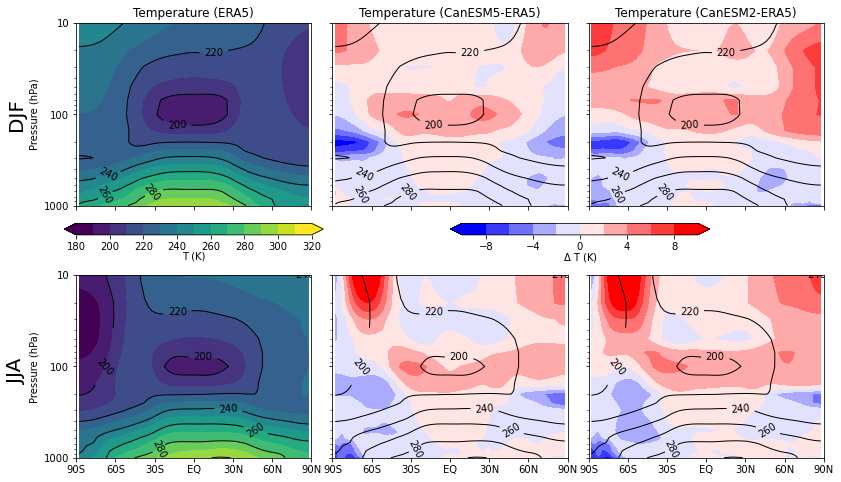

In [7]:
# Compute differences
canesm5_diff_djf = ds_canesm5_climo['ta_zonal'].sel(season="DJF").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="DJF").to_numpy()
canesm5_diff_jja = ds_canesm5_climo['ta_zonal'].sel(season="JJA").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="JJA").to_numpy()
canesm2_diff_djf = ds_canesm2_climo['ta_zonal'].sel(season="DJF").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="DJF").to_numpy()
canesm2_diff_jja = ds_canesm2_climo['ta_zonal'].sel(season="JJA").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="JJA").to_numpy()
#print(canesm5_diff)
# Layout the axes
fig = py.figure(constrained_layout=False,figsize=[12,8])
widths=[4,4,4]
heights=[1,1]
gs1 = fig.add_gridspec(2,3,width_ratios=widths,
                           height_ratios=heights,left=0.085, right=0.95, wspace=0.09,hspace=0.38)
f_ax1 = fig.add_subplot(gs1[0,0])
f_ax2 = fig.add_subplot(gs1[0,1])
f_ax3 = fig.add_subplot(gs1[0,2])
f_ax4 = fig.add_subplot(gs1[1,0])
f_ax5 = fig.add_subplot(gs1[1,1])
f_ax6 = fig.add_subplot(gs1[1,2])

levels1 = np.arange(180,321,10)
levels1_c = np.arange(180,321,20)
levels2 = np.arange(-10,11,2)

cmap1 = py.get_cmap('viridis')
norm1 = BoundaryNorm(levels1, ncolors=cmap1.N, clip=True)

cmap2 = py.get_cmap('bwr')
norm2 = BoundaryNorm(levels2, ncolors=cmap2.N, clip=True)

###################################
# Make the plots
###################################

# Plot the ta from ERA5

f1=f_ax1.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="DJF"),
                  levels=levels1,cmap=cmap1,norm=norm1,extend='both')
cs1=f_ax1.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="DJF"),
                  levels=levels1_c, colors='k',linewidths=1)
f_ax1.clabel(cs1,fmt='%1.0f')
f_ax1.set_title("Temperature (ERA5)")
f_ax1.set_xticks([-90,-60,-30,0,30,60,90])
f_ax1.set_xticklabels([])
f_ax1.set_yscale('log')
f_ax1.set_yticks([1000,100,10])
f_ax1.set_yticklabels(["1000","100","10"])
#a,b=f_ax1.get_ylim()
f_ax1.set_ylim(1000,10)
f_ax1.set_ylabel("Pressure (hPa)")

# Plot the ua bias for CanESM5 relative to ERA5
f2=f_ax2.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm5_diff_djf,
                  levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs2=f_ax2.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="DJF"),
                  levels=levels1_c, colors='k',linewidths=1)
f_ax2.clabel(cs2,fmt='%1.0f')
f_ax2.set_title("Temperature (CanESM5-ERA5)")
f_ax2.set_xticks([-90,-60,-30,0,30,60,90])
f_ax2.set_xticklabels([])
f_ax2.set_yscale('log')
#a,b=f_ax2.get_ylim()
f_ax2.set_ylim(1000,10)
f_ax2.set_yticklabels([])

# Plot the ta bias for CanESM2 relative to ERA5
f3=f_ax3.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm2_diff_djf,
                  levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs3=f_ax3.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="DJF"),
                  levels=levels1_c, colors='k',linewidths=1)
f_ax3.clabel(cs3,fmt='%1.0f')
f_ax3.set_title("Temperature (CanESM2-ERA5)")
f_ax3.set_xticks([-90,-60,-30,0,30,60,90])
f_ax3.set_xticklabels([])
f_ax3.set_yscale('log')
#a,b=f_ax3.get_ylim()
f_ax3.set_ylim(1000,10)
f_ax3.set_yticklabels([])

f4=f_ax4.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="JJA"),
                  levels=levels1,cmap=cmap1,norm=norm1,extend='both')
cs4=f_ax4.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="JJA"),
                  levels=levels1_c, colors='k',linewidths=1)
f_ax4.clabel(cs4,fmt='%1.0f')
#f_ax4.set_title("Temperature (ERA5)")
f_ax4.set_xticks([-90,-60,-30,0,30,60,90])
f_ax4.set_xticklabels(["90S","60S","30S","EQ","30N","60N","90N"])
f_ax4.set_yscale('log')
f_ax4.set_yticks([1000,100,10])
f_ax4.set_yticklabels(["1000","100","10"])
#a,b=f_ax4.get_ylim()
f_ax4.set_ylim(1000,10)
f_ax4.set_ylabel("Pressure (hPa)")

# Plot the ua bias for CanESM5 relative to ERA5
f5=f_ax5.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm5_diff_jja,
                  levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs5=f_ax5.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="JJA"),
                  levels=levels1_c, colors='k',linewidths=1)
f_ax5.clabel(cs5,fmt='%1.0f')
#f_ax5.set_title("Temperature (CanESM5-ERA5)")
f_ax5.set_xticks([-90,-60,-30,0,30,60,90])
f_ax5.set_xticklabels(["90S","60S","30S","EQ","30N","60N","90N"])
f_ax5.set_yscale('log')
#a,b=f_ax5.get_ylim()
f_ax5.set_ylim(1000,10)
f_ax5.set_yticklabels([])

# Plot the ua bias for CanESM2 relative to ERA5
f6=f_ax6.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm2_diff_jja,
                  levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs6=f_ax6.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="JJA"),
                  levels=levels1_c, colors='k',linewidths=1)
f_ax6.clabel(cs6,fmt='%1.0f')
#f_ax6.set_title("Termperature (CanESM2-ERA5)")
f_ax6.set_xticks([-90,-60,-30,0,30,60,90])
f_ax6.set_xticklabels(["90S","60S","30S","EQ","30N","60N","90N"])
f_ax6.set_yscale('log')
#a,b=f_ax6.get_ylim()
f_ax6.set_ylim(1000,10)
f_ax6.set_yticklabels([])

# Add common colorbars
cax1 = py.axes([0.071, 0.512, 0.3, 0.02])
cb1=py.colorbar(f1,cax=cax1,orientation='horizontal')
cb1.set_label(r"T (K)",labelpad=-1)

cax2 = py.axes([0.518, 0.512, 0.3, 0.02])
cb2=py.colorbar(f2,cax=cax2,orientation='horizontal')
cb2.set_label(r"$\Delta$ T (K)",labelpad=-1)

# Add text so it is clear what season is in each row
#tax1 = py.axes([0.025, 0.51, 0.2, 0.02])
fig.text(0.005, 0.7, "DJF", fontsize=20,rotation=90)
fig.text(0.005, 0.26, "JJA", fontsize=20,rotation=90)

Text(0.055, 0.2, 'SON')

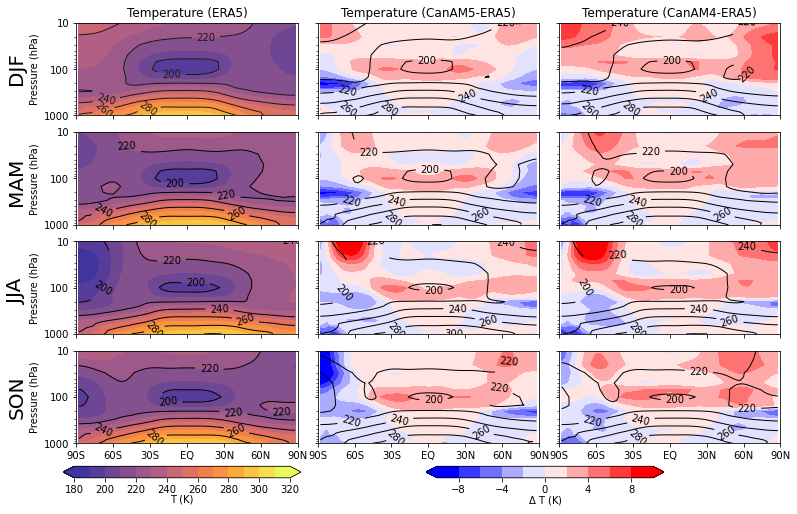

: 

In [8]:
### Show all seasons
# Compute differences
canesm5_diff_djf = ds_canesm5_climo['ta_zonal'].sel(season="DJF").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="DJF").to_numpy()
canesm5_diff_jja = ds_canesm5_climo['ta_zonal'].sel(season="JJA").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="JJA").to_numpy()
canesm5_diff_mam = ds_canesm5_climo['ta_zonal'].sel(season="MAM").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="MAM").to_numpy()
canesm5_diff_son = ds_canesm5_climo['ta_zonal'].sel(season="SON").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="SON").to_numpy()

canesm2_diff_djf = ds_canesm2_climo['ta_zonal'].sel(season="DJF").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="DJF").to_numpy()
canesm2_diff_jja = ds_canesm2_climo['ta_zonal'].sel(season="JJA").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="JJA").to_numpy()
canesm2_diff_mam = ds_canesm2_climo['ta_zonal'].sel(season="MAM").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="MAM").to_numpy()
canesm2_diff_son = ds_canesm2_climo['ta_zonal'].sel(season="SON").to_numpy()-ds_era5_climo['ta_zonal'].sel(season="SON").to_numpy()
#print(canesm5_diff)
# Layout the axes
fig = py.figure(constrained_layout=False,figsize=[12,8])
widths=[4,4,4]
heights=[1,1,1,1]
#gs1 = fig.add_gridspec(4,3,width_ratios=widths,height_ratios=heights,
#                       left=0.085,right=0.95,wspace=0.09,hspace=0.18)
gs1 = fig.add_gridspec(4,3,width_ratios=widths,height_ratios=heights,
                       left=0.135,right=0.95,bottom=0.15,wspace=0.09,
                       hspace=0.18)

f_ax1_1 = fig.add_subplot(gs1[0,0])
f_ax1_2 = fig.add_subplot(gs1[0,1])
f_ax1_3 = fig.add_subplot(gs1[0,2])
f_ax2_1 = fig.add_subplot(gs1[1,0])
f_ax2_2 = fig.add_subplot(gs1[1,1])
f_ax2_3 = fig.add_subplot(gs1[1,2])
f_ax3_1 = fig.add_subplot(gs1[2,0])
f_ax3_2 = fig.add_subplot(gs1[2,1])
f_ax3_3 = fig.add_subplot(gs1[2,2])
f_ax4_1 = fig.add_subplot(gs1[3,0])
f_ax4_2 = fig.add_subplot(gs1[3,1])
f_ax4_3 = fig.add_subplot(gs1[3,2])

levels1 = np.arange(180,321,10)
levels1_c = np.arange(180,321,20)
levels2 = np.arange(-10,11,2)

#cmapt = py.get_cmap('viridis')
#cmapt = py.get_cmap('cividis')
cmapt = cmocean.cm.thermal
cmap1= ListedColormap(cmapt(np.linspace(0.2,1.0,128)))
norm1 = BoundaryNorm(levels1, ncolors=cmap1.N, clip=True)

cmap2 = py.get_cmap('bwr')
norm2 = BoundaryNorm(levels2, ncolors=cmap2.N, clip=True)

###################################
# Make the plots
###################################

# Plot the ta from ERA5

f1_1=f_ax1_1.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="DJF"),
                      levels=levels1,cmap=cmap1,norm=norm1,extend='both')
cs1_1=f_ax1_1.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="DJF"),
                      levels=levels1_c, colors='0.1',linewidths=1)
f_ax1_1.clabel(cs1_1,fmt='%1.0f')
f_ax1_1.set_title("Temperature (ERA5)")
f_ax1_1.set_xticks([-90,-60,-30,0,30,60,90])
f_ax1_1.set_xticklabels([])
f_ax1_1.set_yscale('log')
f_ax1_1.set_yticks([1000,100,10])
f_ax1_1.set_yticklabels(["1000","100","10"])
#a,b=f_ax1.get_ylim()
f_ax1_1.set_ylim(1000,10)
f_ax1_1.set_ylabel("Pressure (hPa)")

# Plot the ua bias for CanESM5 relative to ERA5
f1_2=f_ax1_2.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm5_diff_djf,
                      levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs1_2=f_ax1_2.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_canesm5_climo['ta_zonal'].sel(season="DJF"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax1_2.clabel(cs1_2,fmt='%1.0f')
f_ax1_2.set_title("Temperature (CanAM5-ERA5)")
f_ax1_2.set_xticks([-90,-60,-30,0,30,60,90])
f_ax1_2.set_xticklabels([])
f_ax1_2.set_yscale('log')
#a,b=f_ax2.get_ylim()
f_ax1_2.set_ylim(1000,10)
f_ax1_2.set_yticklabels([])

# Plot the ta bias for CanESM2 relative to ERA5
f1_3=f_ax1_3.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm2_diff_djf,
                      levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs1_3=f_ax1_3.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_canesm2_climo['ta_zonal'].sel(season="DJF"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax1_3.clabel(cs1_3,fmt='%1.0f')
f_ax1_3.set_title("Temperature (CanAM4-ERA5)")
f_ax1_3.set_xticks([-90,-60,-30,0,30,60,90])
f_ax1_3.set_xticklabels([])
f_ax1_3.set_yscale('log')
#a,b=f_ax3.get_ylim()
f_ax1_3.set_ylim(1000,10)
f_ax1_3.set_yticklabels([])

f2_1=f_ax2_1.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="MAM"),
                      levels=levels1,cmap=cmap1,norm=norm1,extend='both')
cs2_1=f_ax2_1.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="MAM"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax2_1.clabel(cs2_1,fmt='%1.0f')
#f_ax4.set_title("Temperature (ERA5)")
f_ax2_1.set_xticks([-90,-60,-30,0,30,60,90])
f_ax2_1.set_xticklabels([])
f_ax2_1.set_yscale('log')
f_ax2_1.set_yticks([1000,100,10])
f_ax2_1.set_yticklabels(["1000","100","10"])
#a,b=f_ax4.get_ylim()
f_ax2_1.set_ylim(1000,10)
f_ax2_1.set_ylabel("Pressure (hPa)")

# Plot the ua bias for CanESM5 relative to ERA5
f2_2=f_ax2_2.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm5_diff_mam,
                      levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs2_2=f_ax2_2.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_canesm5_climo['ta_zonal'].sel(season="MAM"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax2_2.clabel(cs2_2,fmt='%1.0f')
#f_ax5.set_title("Temperature (CanESM5-ERA5)")
f_ax2_2.set_xticks([-90,-60,-30,0,30,60,90])
f_ax2_2.set_xticklabels([])
f_ax2_2.set_yscale('log')
#a,b=f_ax5.get_ylim()
f_ax2_2.set_ylim(1000,10)
f_ax2_2.set_yticklabels([])

# Plot the ua bias for CanESM2 relative to ERA5
f2_3=f_ax2_3.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm2_diff_mam,
                      levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs2_3=f_ax2_3.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_canesm2_climo['ta_zonal'].sel(season="MAM"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax2_3.clabel(cs2_3,fmt='%1.0f')
#f_ax6.set_title("Termperature (CanESM2-ERA5)")
f_ax2_3.set_xticks([-90,-60,-30,0,30,60,90])
f_ax2_3.set_xticklabels([])
f_ax2_3.set_yscale('log')
#a,b=f_ax6.get_ylim()
f_ax2_3.set_ylim(1000,10)
f_ax2_3.set_yticklabels([])

f3_1=f_ax3_1.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="JJA"),
                      levels=levels1,cmap=cmap1,norm=norm1,extend='both')
cs3_1=f_ax3_1.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="JJA"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax3_1.clabel(cs3_1,fmt='%1.0f')
#f_ax4.set_title("Temperature (ERA5)")
f_ax3_1.set_xticks([-90,-60,-30,0,30,60,90])
f_ax3_1.set_xticklabels([])
f_ax3_1.set_yscale('log')
f_ax3_1.set_yticks([1000,100,10])
f_ax3_1.set_yticklabels(["1000","100","10"])
#a,b=f_ax4.get_ylim()
f_ax3_1.set_ylim(1000,10)
f_ax3_1.set_ylabel("Pressure (hPa)")

# Plot the ua bias for CanESM5 relative to ERA5
f3_2=f_ax3_2.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm5_diff_jja,
                      levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs3_2=f_ax3_2.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_canesm5_climo['ta_zonal'].sel(season="JJA"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax3_2.clabel(cs3_2,fmt='%1.0f')
#f_ax5.set_title("Temperature (CanESM5-ERA5)")
f_ax3_2.set_xticks([-90,-60,-30,0,30,60,90])
f_ax3_2.set_xticklabels([])
f_ax3_2.set_yscale('log')
#a,b=f_ax5.get_ylim()
f_ax3_2.set_ylim(1000,10)
f_ax3_2.set_yticklabels([])

# Plot the ua bias for CanESM2 relative to ERA5
f3_3=f_ax3_3.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm2_diff_jja,
                      levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs3_3=f_ax3_3.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_canesm2_climo['ta_zonal'].sel(season="JJA"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax3_3.clabel(cs3_3,fmt='%1.0f')
#f_ax6.set_title("Termperature (CanESM2-ERA5)")
f_ax3_3.set_xticks([-90,-60,-30,0,30,60,90])
f_ax3_3.set_xticklabels([])
f_ax3_3.set_yscale('log')
#a,b=f_ax6.get_ylim()
f_ax3_3.set_ylim(1000,10)
f_ax3_3.set_yticklabels([])

f4_1=f_ax4_1.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="SON"),
                      levels=levels1,cmap=cmap1,norm=norm1,extend='both')
cs4_1=f_ax4_1.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_era5_climo['ta_zonal'].sel(season="SON"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax4_1.clabel(cs4_1,fmt='%1.0f')
#f_ax4.set_title("Temperature (ERA5)")
f_ax4_1.set_xticks([-90,-60,-30,0,30,60,90])
f_ax4_1.set_xticklabels(["90S","60S","30S","EQ","30N","60N","90N"])
f_ax4_1.set_yscale('log')
f_ax4_1.set_yticks([1000,100,10])
f_ax4_1.set_yticklabels(["1000","100","10"])
#a,b=f_ax4.get_ylim()
f_ax4_1.set_ylim(1000,10)
f_ax4_1.set_ylabel("Pressure (hPa)")

# Plot the ua bias for CanESM5 relative to ERA5
f4_2=f_ax4_2.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm5_diff_son,
                      levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs4_2=f_ax4_2.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_canesm5_climo['ta_zonal'].sel(season="SON"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax4_2.clabel(cs4_2,fmt='%1.0f')
#f_ax5.set_title("Temperature (CanESM5-ERA5)")
f_ax4_2.set_xticks([-90,-60,-30,0,30,60,90])
f_ax4_2.set_xticklabels(["90S","60S","30S","EQ","30N","60N","90N"])
f_ax4_2.set_yscale('log')
#a,b=f_ax5.get_ylim()
f_ax4_2.set_ylim(1000,10)
f_ax4_2.set_yticklabels([])

# Plot the ua bias for CanESM2 relative to ERA5
f4_3=f_ax4_3.contourf(ds_era5_climo['lat'],ds_era5_climo['plev'],canesm2_diff_son,
                      levels=levels2,cmap=cmap2,norm=norm2,extend='both')
cs4_3=f_ax4_3.contour(ds_era5_climo['lat'],ds_era5_climo['plev'],ds_canesm2_climo['ta_zonal'].sel(season="SON"),
                      levels=levels1_c, colors='k',linewidths=1)
f_ax4_3.clabel(cs4_3,fmt='%1.0f')
#f_ax6.set_title("Termperature (CanESM2-ERA5)")
f_ax4_3.set_xticks([-90,-60,-30,0,30,60,90])
f_ax4_3.set_xticklabels(["90S","60S","30S","EQ","30N","60N","90N"])
f_ax4_3.set_yscale('log')
#a,b=f_ax6.get_ylim()
f_ax4_3.set_ylim(1000,10)
f_ax4_3.set_yticklabels([])

# Add common colorbars
cax1 = py.axes([0.12, 0.09, 0.275, 0.02])
cb1=py.colorbar(f1_1,cax=cax1,orientation='horizontal')
cb1.set_label(r"T (K)",labelpad=-1)

cax2 = py.axes([0.54, 0.09, 0.275, 0.02])
cb2=py.colorbar(f1_2,cax=cax2,orientation='horizontal')
cb2.set_label(r"$\Delta$ T (K)",labelpad=-1)

# Add text so it is clear what season is in each row
#tax1 = py.axes([0.025, 0.51, 0.2, 0.02])
fig.text(0.055, 0.78, "DJF", fontsize=20,rotation=90)
fig.text(0.055, 0.57, "MAM", fontsize=20,rotation=90)
fig.text(0.055, 0.40, "JJA", fontsize=20,rotation=90)
fig.text(0.055, 0.2, "SON", fontsize=20,rotation=90)